In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

import sys
import pprint
import argparse
import datetime
import random
import copy

from model import Basic
from ql_mpcm import QL_MPCM
from mpcm import MPCM
from utils import *
from dataset import read_data, build_dict, load_glove, preprocess

from time import gmtime, strftime
from matplotlib.table import Table

[nltk_data] Downloading package punkt to /home/jinhyuk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
flags = {}
flags['train_epoch'] = 100
flags['test_epoch'] = 1
flags['batch_size'] = 32
flags['dim_perspective'] = 20
flags['dim_embed_word'] = 300
flags['dim_rnn_cell'] = 100
flags['dim_hidden'] = 100
flags['num_paraphrase'] = 1
flags['rnn_layer'] = 1
flags['context_maxlen'] = 200
flags['validation_cnt'] = 100
flags['rnn_dropout'] = 0.5
flags['hidden_dropout'] = 0.5
flags['embed_dropout'] = 0.8
flags['learning_rate'] = 0.00162
flags['max_grad_norm'] = 5.0
flags['embed_trainable'] = False
flags['test'] = False
flags['debug'] = False
flags['save'] = False
flags['sample_params'] = False
flags['model'] = 'm'
flags['train_path'] = './data/train-v1.1.json'
flags['dev_path'] = './data/dev-v1.1.json'
flags['pred_path'] = './result/dev-v1.1-pred.json'
flags['glove_path'] = '~/common/glove/glove.840B.'+ str(flags['dim_embed_word']) +'d.txt'
flags['checkpoint_dir'] = './result/ckpt'

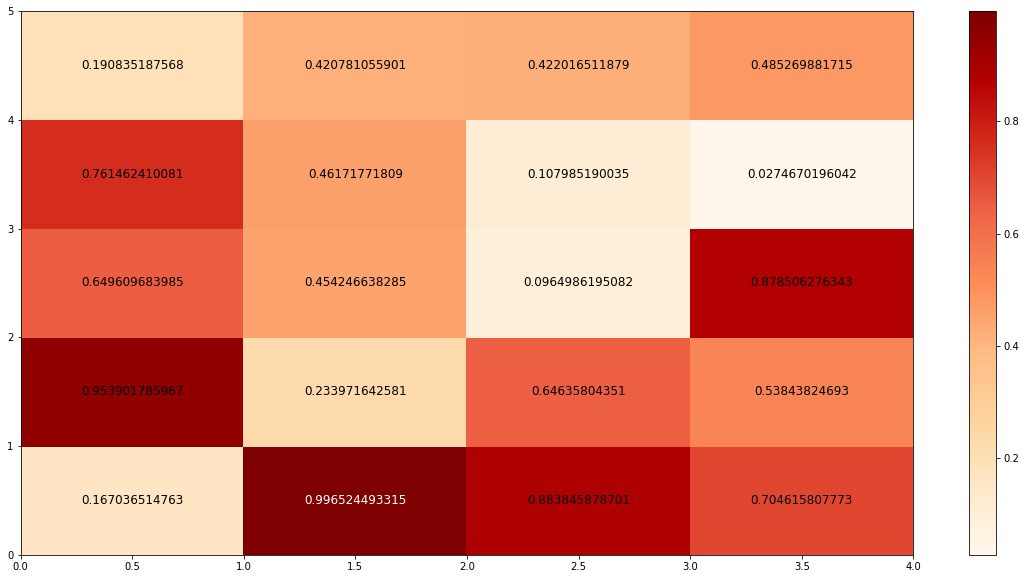

In [3]:
def checkerboard_table(data, text=None):
    data = np.array([i for i in reversed(data)])
    max_idx = np.argmax(data.flatten())
    # print(max_idx)
    heatmap = plt.pcolor(data, cmap='OrRd')
    if text is None:
        text = data
    else:
        text = np.array([i for i in reversed(text)])
    # print(data)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if x + y * data.shape[1] == max_idx:
                color = 'white'
            else:
                color = 'black'
            plt.text(x + 0.5, y + 0.5, '%s' % text[y, x],
                     horizontalalignment='center',
                     verticalalignment='center', color=color, fontsize=12)

    plt.colorbar(heatmap)

plt.figure(figsize=(20,10))
data = np.random.rand(5, 4)
checkerboard_table(data)
plt.show()

In [4]:
# Load dataset once
expected_version = '1.1'
train_path = flags['train_path']
dev_path = flags['dev_path']
train_dataset = read_data(train_path, expected_version)
dev_dataset = read_data(dev_path, expected_version)

# Preprocess dataset
saved_params = flags
word2idx, idx2word, c_maxlen, q_maxlen = build_dict(train_dataset, saved_params)
pretrained_glove, word2idx, idx2word = load_glove(word2idx, saved_params)
if saved_params['context_maxlen'] > 0: 
    c_maxlen = saved_params['context_maxlen']

train_dataset = preprocess(train_dataset, word2idx, c_maxlen, q_maxlen)
dev_dataset = preprocess(dev_dataset, word2idx, c_maxlen, q_maxlen)
saved_params['context_maxlen'] = c_maxlen
saved_params['question_maxlen'] = q_maxlen
saved_params['voca_size'] = len(word2idx)
saved_params['dim_output'] = c_maxlen

Top 20 frequent words among 115725
[('the', 226249), (',', 153792), ('of', 130373), ('.', 94599), ('?', 86971), ('and', 85949), ('in', 77720), ('to', 70230), ('a', 52322), ('What', 37642), ('is', 37116), ('was', 36202), ('"', 29199), ('The', 26296), ('as', 24940), ('for', 23770), ("'s", 23283), ('(', 21446), (')', 21437), ('that', 20756)]
Faces 2
digit cnt 1894
non alpha cnt 23593
Dictionary size 115725
[('!', 0), ('"', 1), ('"Beautiful', 2), ('"Carmen', 3), ('"Deja', 4), ('"Nigeria', 5), ('"The', 6), ('"narrow', 7), ('#', 8), ('$', 9), ('%', 10), ('&', 11), ("'", 12), ("'00", 13), ("'00s", 14), ("'01", 15), ("'02", 16), ("'03", 17), ("'04", 18), ("'040", 19)]
Maxlen of C:766, Q:60, A:46
Glove Loading...
could not convert string to float: '.'
could not convert string to float: 'name@domain.com'
could not convert string to float: '.'
could not convert string to float: 'name@domain.com'
could not convert string to float: '.'
could not convert string to float: '.'
could not convert string

In [112]:
params = copy.deepcopy(flags)
pprint.PrettyPrinter().pprint(params)

# my_model.reset_graph()
# set model name
params['model'] = 'm200_0'

# Make model and run experiment
if 'm' in params['model'] :
    my_model = MPCM(params, initializer=[pretrained_glove, word2idx])
elif 'q' in params['model']:
    my_model = QL_MPCM(params, initializer=[pretrained_glove, word2idx])
elif 'b' in params['model']:
    my_model = Basic(params, initializer=[pretrained_glove, word2idx])
else:
    assert False, "Check your version %s" % params['model']

my_model.load(params['checkpoint_dir'])

{'batch_size': 32,
 'checkpoint_dir': './result/ckpt',
 'context_maxlen': 200,
 'debug': False,
 'dev_path': './data/dev-v1.1.json',
 'dim_embed_word': 300,
 'dim_hidden': 100,
 'dim_output': 200,
 'dim_perspective': 20,
 'dim_rnn_cell': 100,
 'embed_dropout': 0.8,
 'embed_trainable': False,
 'glove_path': '~/common/glove/glove.840B.300d.txt',
 'hidden_dropout': 0.5,
 'learning_rate': 0.00162,
 'max_grad_norm': 5.0,
 'model': 'm',
 'num_paraphrase': 1,
 'pred_path': './result/dev-v1.1-pred.json',
 'question_maxlen': 60,
 'rnn_dropout': 0.5,
 'rnn_layer': 1,
 'sample_params': False,
 'save': False,
 'test': False,
 'test_epoch': 1,
 'train_epoch': 100,
 'train_path': './data/train-v1.1.json',
 'validation_cnt': 100,
 'voca_size': 92938}
### Building MPCM model ###
# Filter_layer Tensor("Filter_Layer/Mul:0", shape=(?, 200, 300), dtype=float32, device=/device:GPU:0)
# Representation_layer Tensor("Representation_Layer/Context/Bi-RNN/concat:0", shape=(?, 200, 200), dtype=float32, device=/de

In [ ]:
model = my_model
sess = model.session
batch_size = params['batch_size']
mini_batch = []
ground_truths = []
context_raws = []
question_raws = []

total_loss = total_f1 = total_em = total_cnt = 0
dataset = dev_dataset

for context_idx, dataset_item in enumerate(dataset[0:400]):
    context = dataset_item['c']
    context_raw = dataset_item['c_raw']
    context_real = dataset_item['c_real']
    context_len = dataset_item['c_len']
    for q_idx, qa in enumerate(dataset_item['qa']):
        question = qa['q']
        question_len = qa['q_len']
        question_raw = qa['q_raw']
        answer = qa['a']
        answer_start = qa['a_start']
        answer_end = qa['a_end']

        ground_truths = [answer]
        context_raws = [context_raw]
        question_raws = [question_raw]

        batch_context = [context]
        batch_context_len = [context_len]
        batch_question = [question]
        batch_question_len = [question_len]
        batch_answer_start = [answer_start]
        batch_answer_end = [answer_end]
        
        if 0:
            paraphrase = 'What city was established before Warszowa ?'
            question_raws = [paraphrase.split(' ')]
            batch_question_len = [len(paraphrase.split(' '))]
            batch_question = [[word2idx[w] if w in word2idx else word2idx['UNK'] for w in paraphrase.split(' ')]]
            while len(batch_question[0]) != model.question_maxlen:
                batch_question[0] = np.append(batch_question[0], word2idx['PAD'])
            
        feed_dict = {model.context: batch_context,
            model.context_len: batch_context_len,
            model.question: batch_question,
            model.question_len: batch_question_len,
            model.answer_start: batch_answer_start,
            model.answer_end: batch_answer_end,
            model.rnn_dropout: 1.0,
            model.hidden_dropout: 1.0,
            model.embed_dropout: 1.0}

        loss, start_logits, end_logits = sess.run(
                [model.loss, model.start_logits, model.end_logits], 
                feed_dict=feed_dict)
        start_idx = [np.argmax(sl[:cl], 0)
                for sl, cl in zip(start_logits, batch_context_len)]
        end_idx = [np.argmax(el[si:cl], 0) + si
                for el, si, cl in zip(end_logits, start_idx, batch_context_len)]
        predictions = []
        
        for c, s_idx, e_idx in zip(context_raws, start_idx, end_idx):
            predictions.append(' '.join([w for w in c[s_idx: e_idx+1]]))
        
        em = f1 = 0
        assert len(predictions) == 1
        for prediction, ground_truth, ctr, qur in zip(
                predictions, ground_truths, context_raws, question_raws):
            
            single_em = metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truth)
            single_f1 = metric_max_over_ground_truths(
                    f1_score, prediction, ground_truth)
            
            test_correct = True if single_f1 > 0 else False
            if not test_correct and np.amax(softmax(start_logits[0])) > 0.8:
                print('### Worst mistakes ### prob:%.3f, idx:%d at context %d, question %d' % (
                    np.amax(softmax(start_logits[0])), np.argmax(start_logits[0]), context_idx, q_idx))
            continue
                                        
            test_c = str(' '.join(ctr))
            print('[context] len=%d\n%s\n' % (len(ctr), test_c))
            # print('[context] len=%d\n%s\n' % (context_len, context_real))
            test_q = str(' '.join(qur))
            print('[question] len=%d\n%s\n' % (len(qur), test_q))
            test_gt = str(ground_truth)
            print('[ground truth]\n%s\n' % test_gt)
            test_pr = str(prediction)
            print('[prediction]\n%s\n' % test_pr)
            
            while len(ctr) != len(start_logits[0]):
                ctr = np.append(ctr, 'PAD')
            
            def softmax(x):
                e_x = np.exp(x - np.max(x))
                return e_x / e_x.sum(axis=0)
            
            plt.figure(figsize=(20,5))
            data = np.reshape(softmax(start_logits[0]), (20, 10))
            text = np.reshape(ctr, (20, 10))
            checkerboard_table(data, text)
            plt.show()
            
            plt.figure(figsize=(20,5))
            data = np.reshape(softmax(end_logits[0]), (20, 10))
            checkerboard_table(data, text)
            plt.show()

            em += single_em
            f1 += single_f1

        _progress = "[loss: %.3f, f1: %.3f, em: %.3f]\n\n" % (loss, f1 /
                len(predictions), em / len(predictions)) 
        # sys.stdout.write(_progress)
        sys.stdout.flush()
        
        # break

In [ ]:
### Worst mistakes ### prob:0.825, idx:50 at context 2, question 11
### Worst mistakes ### prob:0.802, idx:50 at context 2, question 20
### Worst mistakes ### prob:0.858, idx:117 at context 8, question 3
### Worst mistakes ### prob:0.805, idx:11 at context 10, question 14
### Worst mistakes ### prob:0.930, idx:40 at context 15, question 8
### Worst mistakes ### prob:0.981, idx:37 at context 16, question 4
### Worst mistakes ### prob:0.969, idx:37 at context 16, question 5
### Worst mistakes ### prob:0.932, idx:37 at context 16, question 11
### Worst mistakes ### prob:0.810, idx:38 at context 24, question 6
### Worst mistakes ### prob:0.938, idx:26 at context 24, question 17
### Worst mistakes ### prob:0.888, idx:41 at context 25, question 8
### Worst mistakes ### prob:0.927, idx:16 at context 30, question 4
### Worst mistakes ### prob:0.818, idx:51 at context 31, question 6
### Worst mistakes ### prob:0.911, idx:27 at context 35, question 3
### Worst mistakes ### prob:0.894, idx:27 at context 35, question 11
### Worst mistakes ### prob:0.820, idx:30 at context 37, question 3
### Worst mistakes ### prob:0.854, idx:27 at context 38, question 11
### Worst mistakes ### prob:0.930, idx:42 at context 41, question 5
### Worst mistakes ### prob:0.826, idx:32 at context 43, question 2
### Worst mistakes ### prob:0.852, idx:32 at context 43, question 3
### Worst mistakes ### prob:0.867, idx:110 at context 44, question 3
### Worst mistakes ### prob:0.988, idx:71 at context 46, question 0
### Worst mistakes ### prob:0.988, idx:71 at context 46, question 2
### Worst mistakes ### prob:0.962, idx:71 at context 46, question 5
### Worst mistakes ### prob:0.800, idx:134 at context 47, question 1
### Worst mistakes ### prob:0.912, idx:31 at context 67, question 0
### Worst mistakes ### prob:0.842, idx:85 at context 77, question 3
### Worst mistakes ### prob:0.888, idx:39 at context 82, question 1
### Worst mistakes ### prob:0.839, idx:109 at context 117, question 1
### Worst mistakes ### prob:0.934, idx:112 at context 136, question 8
### Worst mistakes ### prob:0.828, idx:14 at context 137, question 7
### Worst mistakes ### prob:0.835, idx:1 at context 138, question 4
### Worst mistakes ### prob:0.802, idx:92 at context 151, question 3
### Worst mistakes ### prob:0.845, idx:153 at context 180, question 2
### Worst mistakes ### prob:0.824, idx:27 at context 183, question 1
### Worst mistakes ### prob:0.949, idx:117 at context 193, question 2
### Worst mistakes ### prob:0.925, idx:17 at context 194, question 0
### Worst mistakes ### prob:0.983, idx:14 at context 208, question 2
### Worst mistakes ### prob:0.875, idx:34 at context 211, question 0
### Worst mistakes ### prob:0.870, idx:35 at context 228, question 0
### Worst mistakes ### prob:0.858, idx:10 at context 238, question 1
### Worst mistakes ### prob:0.920, idx:150 at context 240, question 4
### Worst mistakes ### prob:0.883, idx:55 at context 243, question 1
### Worst mistakes ### prob:0.921, idx:8 at context 244, question 0
### Worst mistakes ### prob:0.812, idx:7 at context 249, question 2
### Worst mistakes ### prob:0.934, idx:14 at context 270, question 3
### Worst mistakes ### prob:0.818, idx:53 at context 273, question 2
### Worst mistakes ### prob:0.839, idx:13 at context 280, question 2
### Worst mistakes ### prob:0.891, idx:7 at context 281, question 1
### Worst mistakes ### prob:0.841, idx:7 at context 281, question 4
### Worst mistakes ### prob:0.804, idx:52 at context 285, question 3
### Worst mistakes ### prob:0.916, idx:23 at context 311, question 3
### Worst mistakes ### prob:0.877, idx:53 at context 315, question 4
### Worst mistakes ### prob:0.850, idx:99 at context 316, question 0
### Worst mistakes ### prob:0.971, idx:0 at context 321, question 0
### Worst mistakes ### prob:0.846, idx:155 at context 324, question 4
### Worst mistakes ### prob:0.851, idx:28 at context 325, question 0
### Worst mistakes ### prob:0.805, idx:32 at context 357, question 1
### Worst mistakes ### prob:0.926, idx:54 at context 365, question 4
### Worst mistakes ### prob:0.888, idx:55 at context 372, question 0
### Worst mistakes ### prob:0.826, idx:53 at context 377, question 4
### Worst mistakes ### prob:0.858, idx:28 at context 380, question 0


### Worst mistakes ### prob:0.988, idx:71 at dataset 46   => Ealy parpahrase problem
### Worst mistakes ### prob:0.912, idx:31 at dataset 67   => Jazdów substitue problem
### Worst mistakes ### prob:0.925, idx:17 at dataset 194
### Worst mistakes ### prob:0.875, idx:34 at dataset 211
### Worst mistakes ### prob:0.870, idx:35 at dataset 228
### Worst mistakes ### prob:0.921, idx:8 at dataset 244
### Worst mistakes ### prob:0.850, idx:99 at dataset 316
### Worst mistakes ### prob:0.971, idx:0 at dataset 321
### Worst mistakes ### prob:0.851, idx:28 at dataset 325
### Worst mistakes ### prob:0.888, idx:55 at dataset 372
### Worst mistakes ### prob:0.858, idx:28 at dataset 380